# Datasets and Dataloaders

Code for processing data samples can get complex and hard to maintain. We typically want our dataset code to be decoupled from our model training code, for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that enable you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of sample pre-loaded datasets (such as **_FashionMNIST_**) that subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data. Samples for prototyping and benchmarking your model include: 
- Image Datasets
- Text Datasets
- Audio Datasets

## Loading a dataset

We will be loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of of 60,000 training examples and 10,000 test examples.  Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.  

 - Each image is 28 pixels in height and 28 pixels in width, with a total of 784 pixels
 - The 10 classes tell what type of image it is, for example: T-shirt/top, Trouser, Pullover, Dress, Bag, Ankle boot etc.
 - The grayscale pixels have values between 0 to 255 that measure the intensity of black and white images.  The intensity value increase from white to black. For example:  a white color is 0, while a black color is 255.
 
 ![Image showing grayscale image pixels and values.](../images/3-data-1.png)


We load the FashionMNIST Dataset with the following parameters:
 - **root** is the path where the train/test data is stored.
 - **train** specifies training or test dataset.
 - **download=True** downloads the data from the Internet if it's not available at `root`.
 - **transform** and `target_transform` specify the feature and label transformations.

In [1]:
%matplotlib inline
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and visualizing the Dataset
-----------------

We can index ``Datasets`` manually like a list: ``training_data[index]``. 
We use ``matplotlib`` to visualize some samples in our training data.

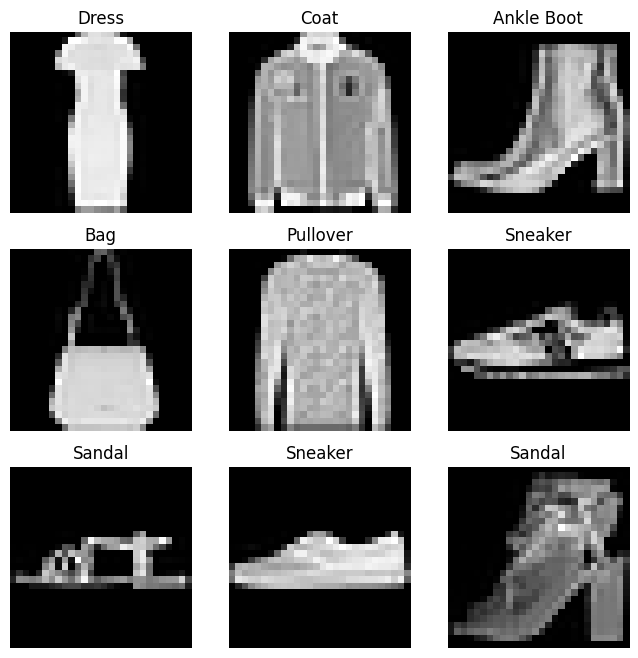

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Preparing your data for training with DataLoaders
-------------------------------------------------
The ``Dataset`` retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to 
pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's multiprocessing to
speed up data retrieval.

In machine learning, you need to specify the features and labels in your dataset. **Features** are input and **labels** are output. We train features and then train the model to predict the label.

  - Features are the patterns in the images pixels
  - Labels are our 10 class types:  T-shirt, Sandal, Dress, etc

The ``DataLoader`` is an iterable that abstracts this complexity for us in a simpler API. To use the Dataloader, we need to set the following parameters:

 - **data** the training data that will be used to train the model, and the test data to evaluate the model
 - **batch size** the number of records to be processed in each batch
 - **shuffle** the random sample of the data by indices


In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader

We have loaded that dataset into the `Dataloader` and can now iterate through the dataset as needed.
Each iteration below returns a batch of `train_features` and `train_labels`(containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled, for finer-grained control over the data loading order.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


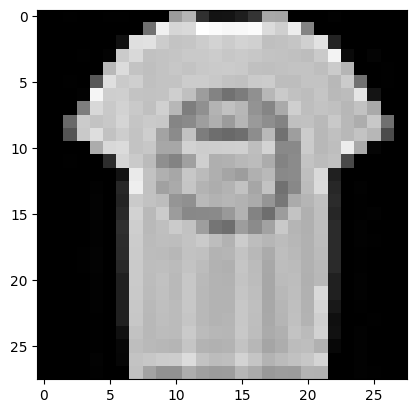

Label: T-Shirt


In [4]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
label_name = list(labels_map.values())[label]
print(f"Label: {label_name}")

# Normalization

Normalization is a common data pre-processing technique that is applied to scale or transform the data to make sure there's an equal learning contribution from each feature. For example, each pixel in the grayscale images have a value between 0 and 255, which are features. If one pixel value is 17 and another pixel is 197. There will be an uneven distribution of the pixel importance, because the higher pixel volumes will deviate the learning. Normalization changes the range of your data, without distorting its distinction among our features. This pre-processing is done to avoid:

- A reduction of the prediction accuracy 
- Difficulty for the model to learn
- Unfavorable distribution of the feature data ranges

## Transforms

Data does not always come in the final processed form that is required for 
training machine learning algorithms. We use **transforms** to manipulate the data and make it suitable for training.

All TorchVision datasets have two parameters (`transform` to modify the features and
`target_transform` to modify the labels) that accept callables containing the transformation logic. The `torchvision.transforms` module offers 
several commonly-used transforms out of the box.

The FashionMNIST features are in PIL Image format, and the labels are integers.
For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.
To make these transformations, we'll use `ToTensor` and `Lambda`.

In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

## ToTensor()

`ToTensor` converts a PIL image or NumPy `ndarray` into a `FloatTensor` and scales the image's pixel intensity values into the range \[0., 1.\]

## Lambda transforms

Lambda transforms apply any user-defined lambda function. Here, we define a function 
to turn the integer into a one-hot encoded tensor. 
It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter which assigns a 
_value=1_ on the index as given by the label _y_. You can also use `torch.nn.functional.one_hot` as another option to do that.

In [6]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))